# Traitement et cleaning de nos bases 

## Description et analyse de complétude

### Liste des variables

Liste des variables présentes le fichier sampled_data_full_fields.jsonl, classées par thématique (+ courte description) :

#### 1. Métadonnées de scraping

* **url** : lien complet vers la page de l’offre.
* **site\_name** : nom du site source (ex. “cadremploi”).
* **site\_child** : sous-section du site (généralement vide ou NaN).
* **date\_scraping** : date et heure exactes du passage du scraper.
* **scrapingFailure\_status** : indique si le scraping a échoué (false = OK).

#### 2. Historique de visibilité

* **date\_firstSeenDay** : première date (JJ-MM-AAAA) où l’offre a été détectée.
* **date\_lastSeenDay** : dernière date où l’offre a été encore visible.
* **date\_firstDisappearedDay** : date à partir de laquelle l’offre n’a plus été retrouvée.

#### 3. Identifiants internes

* **ID\_JOCAS** : identifiant unique généré (site + date + indice).
* **MATCH\_url\_ID**, **MATCH\_url** : identifiants et flag pour la détection de doublons d’URL.
* **MATCH\_dedup\_ID**, **MATCH\_dedup** : idem, pour la déduplication générale.
* **MATCH\_dedup\_Tensions\_ID**, **MATCH\_dedup\_Tensions** : idem, mais en cas de conflits/doublons de « tensions ».

#### 4. Dates liées à l’offre

* **date\_sitePublicationDay** : date de publication déclarée par le site.

#### 5. Détails du poste

* **job\_title** : intitulé du poste (ex. “Expert-comptable F/H”).
* **job\_ROME\_code** : code ROME (répertoire des métiers) correspondant.
* **job\_qualification** : niveau de qualification attendu (souvent vide).
* **contractType** : type de contrat (CDI, CDD, intérim…).
* **contractDuration\_min**, **contractDuration\_max**, **contractDuration\_period**, **contractDuration\_value** : durée du contrat (si CDD), en bornes/min/max et unité (mois, années…).
* **workTime\_hours**, **workTime\_category**, **workTime\_value** : temps de travail (hebdo, plein temps, partiel…), nombre d’heures ou catégorie.

#### 6. Descriptions textuelles

* **description\_job** : description concise des missions.
* **description\_profil** : résumé du profil recherché / exigences.
* **description\_entreprise** : présentation de l’entreprise ou de l’annonceur.
* **description\_full** : HTML complet combinant mission, profil, publication.

#### 7. Localisation

* **location\_label** : nom de la ville ou du département (ex. “Rennes”).
* **location\_zipcode** : code postal (peut être flottant).
* **location\_departement** : code département (ex. “35”).
* **location\_country** : pays (souvent NaN).

#### 8. Rémunération

* **salary\_min**, **salary\_max** : salaire brut minimal et maximal (si indiqué).
* **salary\_period** : période de référence (an, mois, jour…).
* **salary\_value** : valeur unique (quand pas de fourchette).
* **salary\_hourly\_mean**, **salary\_hourly\_min**, **salary\_hourly\_max** : rémunération horaire moyenne et bornes.

#### 9. Informations entreprise

* **entreprise\_nom** : nom de l’employeur.
* **entreprise\_siren** : numéro SIREN (souvent manquant).
* **entrepriseSecteur\_NAF88**, **entrepriseSecteur\_NAF21** : codes NAF / APE (secteurs d’activité).

#### 10. Partenaires et statut

* **partner\_name** : nom du partenaire recruteur (le cas échéant).
* **partner\_status** : indique si l’offre provient d’un partenaire (true/false).

#### 11. Télétravail

* **teleworking\_mentioned** : mention explicite du télétravail (true/false).
* **teleworking\_accepted** : accepte le télétravail (true/false ou NaN).
* **teleworking\_type** : type (partiel, total…).
* **teleworking** : indicateur binaire (1 ou 0).

#### 12. Expérience et formation

* **experience\_min**, **experience\_max** : années d’expérience requises.
* **education\_level** : niveau d’études minimum (bac, bac+3…).
* **education\_field** : domaine d’études (commerce, ingénierie…).

#### 13. Autres

* **ROME\_LOC\_FIRM** : flag indiquant si le code ROME correspond à un poste en entreprise (true/false).


### Étude des erreurs (doublons ou meme ID avec différentes valeurs)

#### Run pour afficher me nombre de doublons, si les variables sont égales, si des variables changes parmi des doublons d'ID_JOCAS (problèmatique...)

In [31]:
import os
import pandas as pd
from rich.console import Console
from rich.table import Table
import json
import warnings
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from collections import Counter
from IPython.display import display
import matplotlib.pyplot as plt
import re

path = '/Users/noeamar/Documents/HEC/Jocas-HEC/Data/sampled_data_full_fields.jsonl'

In [ ]:
# 1. Lecture manuelle du JSONL
records = []
with open(path, encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 2. Silencer les warnings de parsing de date
warnings.filterwarnings("ignore", message=".*Could not infer format.*")

# 3. Conversion explicite des colonnes "date_*" en datetime YYYY-MM-DD
date_cols = [c for c in df.columns if c.startswith("date_")]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], format="%Y-%m-%d", errors="coerce")

# Vue d’ensemble du dataset
n = len(df)
p = df.shape[1]
overview_df = pd.DataFrame({
    "Metric": ["Total de lignes (n)", "Total de variables (p)"],
    "Valeur": [n, p]
})

# Répartition par type de variable
type_map = {}
for col in df.columns:
    s = df[col]
    if is_bool_dtype(s):
        typ = "booléen"
    elif is_numeric_dtype(s):
        typ = "numérique"
    elif pd.api.types.is_datetime64_any_dtype(s):
        typ = "date"
    else:
        avg_len = s.dropna().astype(str).map(len).mean() or 0
        typ = "texte" if avg_len > 30 else "catégoriel"
    type_map[col] = typ

dist = Counter(type_map.values())
type_df = (
    pd.DataFrame.from_dict(dist, orient="index", columns=["Nombre"])
      .reset_index()
      .rename(columns={"index": "Type de variable"})
)

# Affichage stylé dans le notebook
display(
    overview_df.style
        .hide(axis="index")
        .set_caption("💡 Vue d'ensemble du dataset")
        .set_table_styles([{"selector": "caption", "props": [("font-size", "1.2em"), ("font-weight", "bold")]}])
)

display(
    type_df.style
        .hide(axis="index")
        .set_caption("📊 Répartition par type de variable")
        .set_table_styles([{"selector": "caption", "props": [("font-size", "1.2em"), ("font-weight", "bold")]}])
)


Metric,Valeur
Total de lignes (n),50000
Total de variables (p),57


Type de variable,Nombre
texte,8
date,5
catégoriel,20
booléen,6
numérique,18


In [15]:
import pandas as pd

# 1. Charger le fichier
df = pd.read_json(path, lines=True)

# 2. Comptage des occurrences de chaque ID_JOCAS
counts = df['ID_JOCAS'].value_counts()

# 3. IDs apparaissant au moins deux fois
dup_ids = counts[counts > 1].index.tolist()
num_dup_ids = len(dup_ids)

# 4. Préparer la comparaison en traitant les NaN
df_filled = df.fillna('<NA>')

# 5. Identifier les groupes dont toutes les lignes sont strictement identiques
exact_ids = []
for id_val in dup_ids:
    sub = df_filled[df_filled['ID_JOCAS'] == id_val]
    # on retire la colonne d’ID pour comparer toutes les autres variables
    sub_rows = sub.drop(columns='ID_JOCAS')
    if len(sub_rows.drop_duplicates()) == 1:
        exact_ids.append(id_val)
num_exact_ids = len(exact_ids)

# 6. Ceux dont les lignes diffèrent
num_nonidentical_ids = num_dup_ids - num_exact_ids

# 7. Affichage des résultats
print(f"Nombre d'ID_JOCAS apparaissant au moins deux fois : {num_dup_ids}")
print(f"Nombre d'ID_JOCAS avec lignes strictement identiques  : {num_exact_ids}")
print(f"Nombre d'ID_JOCAS avec lignes différentes           : {num_nonidentical_ids}")


Nombre d'ID_JOCAS apparaissant au moins deux fois : 0
Nombre d'ID_JOCAS avec lignes strictement identiques  : 0
Nombre d'ID_JOCAS avec lignes différentes           : 0
Liste du nombre d'offres total dans la base de données : 50000


### Cleaning

### Étude de la complétude par variable

####  Run pour afficher par variable le nombre et la part de null, par ordre décroissant

#### Meme chose en plus lisible

In [ ]:
def analyze_missing_colored(input_path: str):
    """
    Parcourt le fichier JSONL, calcule pour chaque variable :
      - nombre de valeurs manquantes (NaN, None ou chaînes vides)
      - pourcentage de valeurs manquantes
    Affiche le tout dans un tableau coloré selon la part de manquants :
      0–20%   vert
      20–40%  jaune
      40–60%  orange clair
      60–80%  orange foncé
      80–100% rouge
    """
    if not os.path.isfile(input_path):
        raise FileNotFoundError(f"Fichier introuvable : {input_path}")

    # Lecture et nettoyage des chaînes vides
    df = pd.read_json(input_path, lines=True)
    df = df.replace(r'^\s*$', pd.NA, regex=True)

    total = len(df)
    stats = []
    for col in df.columns:
        num_missing = df[col].isna().sum()
        pct_missing = (num_missing / total) * 100
        stats.append((col, num_missing, pct_missing))

    # Tri par nombre de manquants croissant
    stats.sort(key=lambda x: x[1])

    # Préparation du tableau Rich
    table = Table(title="Statistiques de valeurs manquantes", show_lines=True)
    table.add_column("Variable", justify="left", overflow="fold")
    table.add_column("Nuls", justify="right")
    table.add_column("% Nuls", justify="right")

    console = Console()
    for col, num_missing, pct in stats:
        # Choix de la couleur de la ligne
        if pct < 20:
            row_style = "green"
        elif pct < 40:
            row_style = "yellow"
        elif pct < 60:
            row_style = "orange1"
        elif pct < 80:
            row_style = "dark_orange"
        else:
            row_style = "red"
        table.add_row(col, str(num_missing), f"{pct:.2f}%", style=row_style)

    console.print(table)


analyze_missing_colored(path)

## Retirer les colonnes avec trop de valeurs manquantes
threshold = 0.2  # Seuil de 50%
df = df.loc[:, df.isna().mean() < threshold]
print(f"Nombre de colonnes après retrait de celles avec plus de {threshold*100}% de valeurs manquantes : {len(df.columns)}")
print(df.columns.tolist())


      Statistiques de valeurs manquantes      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓
┃ Variable                 ┃  Nuls ┃  % Nuls ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩
│ url                      │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ date_firstSeenDay        │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ date_scraping            │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ site_name                │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ scrapingFailure_status   │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ ID_JOCAS                 │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ MATCH_url                │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ MATCH_dedup_Tensions     │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ job_title                │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ contractType             │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ partner_status           │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ teleworking_mentioned    │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ ROME_LOC_FIRM            │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ teleworking              │     0 │   0.00% │
├──────────────────────────┼───────┼─────────┤
│ description_full         │    13 │   0.03% │
├──────────────────────────┼───────┼─────────┤
│ job_ROME_code            │    31 │   0.06% │
├──────────────────────────┼───────┼─────────┤
│ location_departement     │   493 │   0.99% │
├──────────────────────────┼───────┼─────────┤
│ location_label           │  1678 │   3.36% │
├──────────────────────────┼───────┼─────────┤
│ date_sitePublicationDay  │  2524 │   5.05% │
├──────────────────────────┼───────┼─────────┤
│ entreprise_nom           │  2836 │   5.67% │
├──────────────────────────┼───────┼─────────┤
│ description_job          │  3327 │   6.65% │
├──────────────────────────┼───────┼─────────┤
│ location_zipcode         │  7267 │  14.53% │
├──────────────────────────┼───────┼─────────┤
│ date_firstDisappearedDay │  9395 │  18.79% │
├──────────────────────────┼───────┼─────────┤
│ date_lastSeenDay         │  9395 │  18.79% │
├──────────────────────────┼───────┼─────────┤
│ MATCH_dedup              │ 12145 │  24.29% │
├──────────────────────────┼───────┼─────────┤
│ description_profil       │ 21745 │  43.49% │
├──────────────────────────┼───────┼─────────┤
│ partner_name             │ 27144 │  54.29% │
├──────────────────────────┼───────┼─────────┤
│ description_entreprise   │ 28252 │  56.50% │
├──────────────────────────┼───────┼─────────┤
│ experience_min           │ 30525 │  61.05% │
├──────────────────────────┼───────┼─────────┤
│ experience_max           │ 36486 │  72.97% │
├──────────────────────────┼───────┼─────────┤
│ location_country         │ 37111 │  74.22% │
├──────────────────────────┼───────┼─────────┤
│ education_level          │ 37949 │  75.90% │
├──────────────────────────┼───────┼─────────┤
│ salary_min               │ 38341 │  76.68% │
├──────────────────────────┼───────┼─────────┤
│ salary_period            │ 40329 │  80.66% │
├──────────────────────────┼───────┼─────────┤
│ salary_value             │ 40329 │  80.66% │
├──────────────────────────┼───────┼─────────┤
│ salary_hourly_mean       │ 40329 │  80.66% │
├──────────────────────────┼───────┼─────────┤
│ salary_hourly_min        │ 40329 │  80.66% │
├──────────────────────────┼───────┼─────────┤
│ MATCH_dedup_Tensions_ID  │ 42600 │  85.20% │
├──────────────────────────┼───────┼─────────┤
│ workTime_value           │ 42734 │  85.47% │
├──────────────────────────┼───────┼─────────┤
│ workTime_category        │ 42780 │  85.56% │
├──────────────────────────┼───────┼─────────┤
│ salary_max               │ 43122 │  86.24% │
├────

Nombre de colonnes après retrait de celles avec plus de 20.0% de valeurs manquantes : 24
['url', 'date_firstSeenDay', 'date_scraping', 'site_name', 'scrapingFailure_status', 'ID_JOCAS', 'date_firstDisappearedDay', 'date_lastSeenDay', 'MATCH_url', 'MATCH_dedup_Tensions', 'date_sitePublicationDay', 'job_title', 'job_ROME_code', 'contractType', 'description_job', 'description_full', 'location_label', 'location_zipcode', 'location_departement', 'entreprise_nom', 'partner_status', 'teleworking_mentioned', 'ROME_LOC_FIRM', 'teleworking']


#### Vue d’ensemble du dataset

#### Analyse des variables numériques

,Variable,Non-null,Moyenne,Écart-type,Min,25 %,50 %,75 %,Max,Unique valeurs,Coef. variation
0,location_zipcode,42733,54387.19,25951.75,1000.00,33680.00,57100.00,75000.00,99000.00,4164,0.48
1,salary_min,11659,23679.54,17902.13,9.00,18000.00,22000.00,30000.00,294000.00,502,0.76
2,salary_max,6878,32989.97,22384.57,10.30,22000.00,31000.00,44000.00,367500.00,282,0.68
3,salary_value,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,614,17.06
4,salary_hourly_min,9671,31.97,565.18,0.07,12.45,15.56,21.79,27000.00,429,17.68
5,salary_hourly_max,6350,39.27,630.79,0.18,15.82,21.79,28.01,30000.00,278,16.06
6,salary_hourly_mean,9671,34.73,592.69,0.07,13.38,17.12,23.34,28500.00,607,17.07
7,contractDuration_min,2172,9.81,24.46,0.00,4.00,6.00,6.00,381.00,83,2.49
8,contractDuration_max,2170,9.83,24.46,1.00,4.00,6.00,6.00,381.00,82,2.49
9,contractDuration_value,2172,130.78,98.02,0.00,65.00,130.00,130.00,780.00,96,0.75


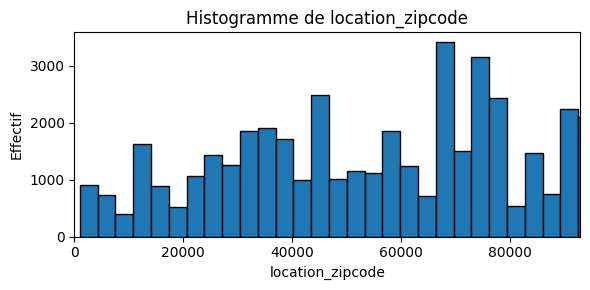

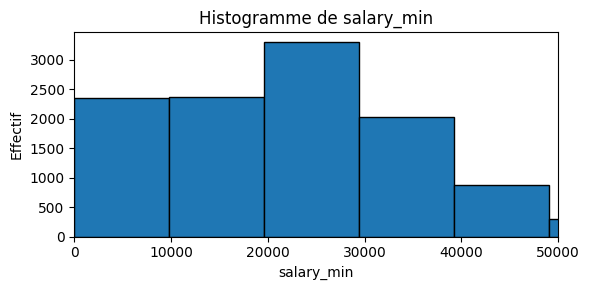

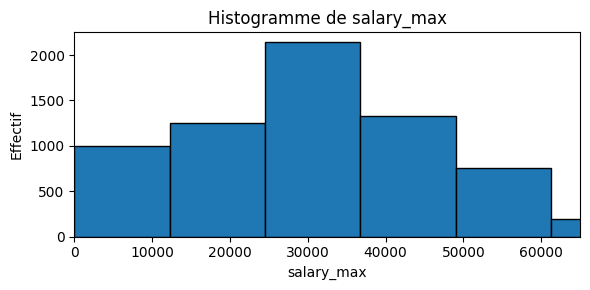

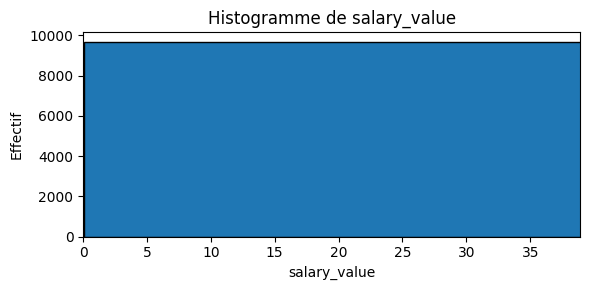

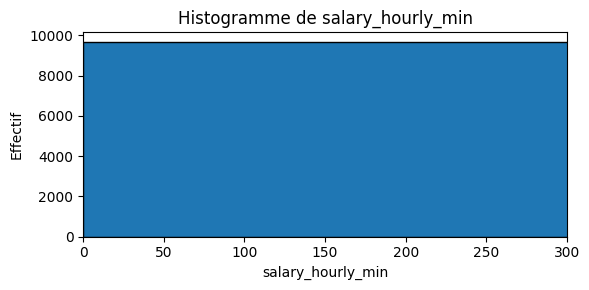

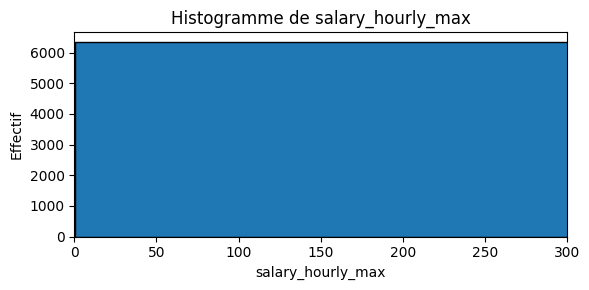

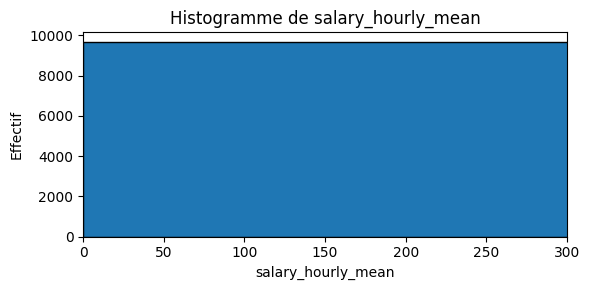

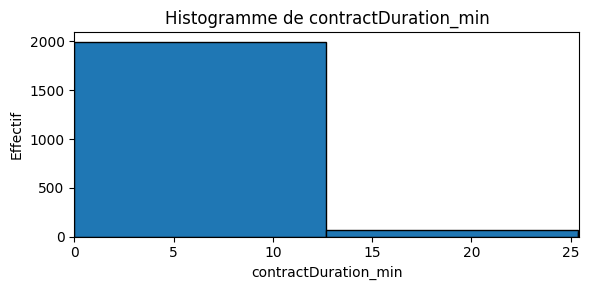

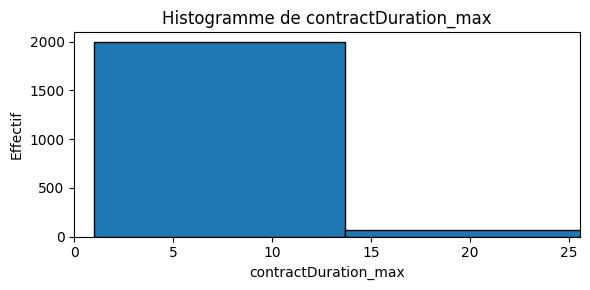

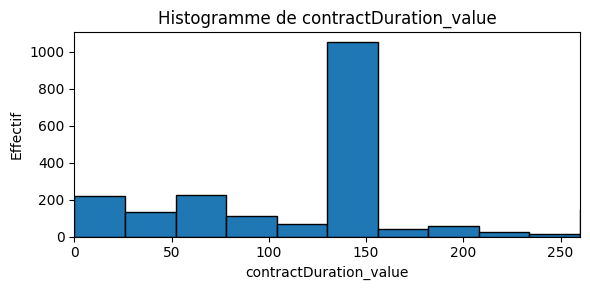

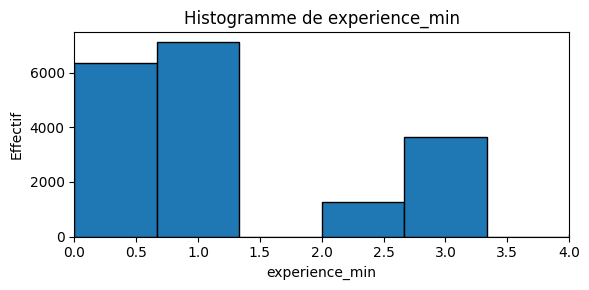

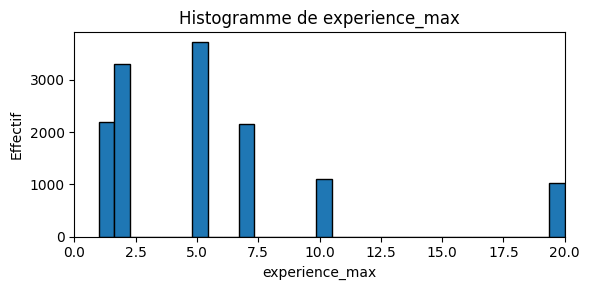

In [23]:
import json
import pandas as pd
from IPython.display import display
from collections import OrderedDict
from pandas.api.types import is_numeric_dtype


# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Liste des variables numériques à analyser
numeric_vars = [
    "location_zipcode", "salary_min", "salary_max", "salary_value",
    "salary_hourly_min", "salary_hourly_max", "salary_hourly_mean",
    "contractDuration_min", "contractDuration_max", "contractDuration_value",
    "workTime_hours", "experience_min", "experience_max"
]

# 4️⃣ Calcul des métriques descriptives
metrics = []
for var in numeric_vars:
    if var in df.columns and is_numeric_dtype(df[var]):
        s = pd.to_numeric(df[var], errors='coerce').dropna()
        if s.empty:
            continue
        metrics.append(OrderedDict([
            ("Variable",        var),
            ("Non-null",        int(s.count())),
            ("Moyenne",         s.mean()),
            ("Écart-type",      s.std()),
            ("Min",             s.min()),
            ("25 %",            s.quantile(0.25)),
            ("50 %",            s.median()),
            ("75 %",            s.quantile(0.75)),
            ("Max",             s.max()),
            ("Unique valeurs",   s.nunique()),
            ("Coef. variation", s.std() / s.mean() if s.mean() else float('nan'))
        ]))

metrics_df = pd.DataFrame(metrics)

# 5️⃣ Tableau stylé avec la colonne Variable visible
styled = (
    metrics_df
      .style
      .format("{:.2f}", subset=["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max","Coef. variation"])
      # .background_gradient(subset=["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max","Coef. variation"], cmap="Blues")  # <- commenter ici
      .set_caption("📊 Statistiques descriptives – Variables numériques")
)
display(styled)

# 6️⃣ Histogrammes avec abscisses adaptées
for var in metrics_df["Variable"]:
    s = pd.to_numeric(df[var], errors='coerce').dropna()
    if s.empty:
        continue
    
    plt.figure(figsize=(6,3))
    plt.hist(s, bins=30, edgecolor='black')
    plt.title(f"Histogramme de {var}")
    plt.xlabel(var)
    plt.ylabel("Effectif")

    # Ajustement dynamique de l'axe x
    if var.startswith("salary_hourly"):
        plt.xlim(0, 300)
    elif var.startswith("contractDuration"):
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    elif var == "salary_value":
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    else:
        lim = s.quantile(0.95)
        plt.xlim(0, lim)
    
    plt.tight_layout()
    plt.show()


#### Variables de date

,Variable,Non-null,Min,Max,Amplitude (jours)
0,date_firstSeenDay,50000,2019-01-10,2022-12-08,1428
1,date_lastSeenDay,40605,2019-01-10,2023-04-26,1567
2,date_firstDisappearedDay,40605,2019-01-11,2023-04-27,1567
3,date_sitePublicationDay,47476,2018-12-18,2022-12-08,1451


,Métrique,Valeur (jours)
0,Temps moyen de détection,1.390000


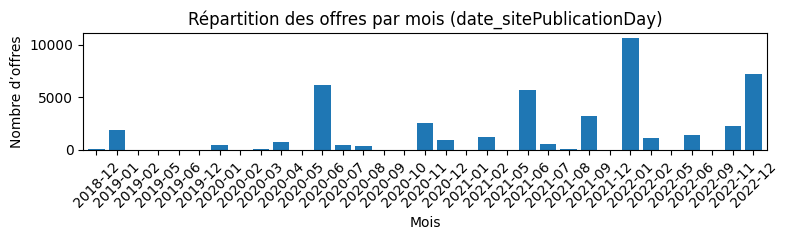

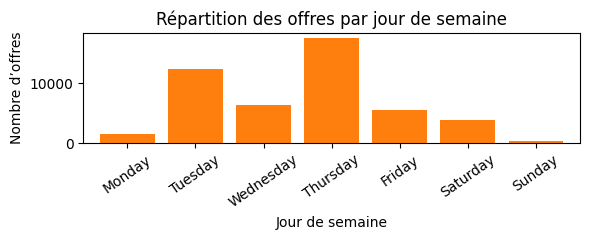

In [25]:
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 2️⃣ Conversion des colonnes date
date_vars = [
    'date_firstSeenDay',
    'date_lastSeenDay',
    'date_firstDisappearedDay',
    'date_sitePublicationDay'
]
for col in date_vars:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

# 3️⃣ Calcul des métriques descriptives pour dates
metrics = []
for col in date_vars:
    series = df[col].dropna()
    if series.empty:
        continue
    min_date = series.min()
    max_date = series.max()
    amp = (max_date - min_date).days
    metrics.append(OrderedDict([
        ('Variable', col),
        ('Non-null', int(series.count())),
        ('Min', min_date.date()),
        ('Max', max_date.date()),
        ('Amplitude (jours)', amp)
    ]))
metrics_df = pd.DataFrame(metrics)

# 4️⃣ Calcul de la moyenne de jours entre publication et première vue
# on suppose existence de date_sitePublicationDay et date_firstSeenDay
diff = (df['date_firstSeenDay'] - df['date_sitePublicationDay']).dt.days.dropna()
avg_diff = diff.mean().round(2)
diff_df = pd.DataFrame([{
    'Métrique': 'Temps moyen de détection',
    'Valeur (jours)': avg_diff
}])

# 5️⃣ Affichage des tableaux
styled_dates = (
    metrics_df
      .style
      .set_caption("📅 Statistiques descriptives – Variables de date")
      .format({'Min': lambda d: d, 'Max': lambda d: d})
)
display(styled_dates)

styled_diff = (
    diff_df
      .style
      .set_caption("⏱️ Nombre de jours moyen entre publication et première détection")
)
display(styled_diff)

# 6️⃣ Séries temporelles pour date_sitePublicationDay
pub = df['date_sitePublicationDay'].dropna()
if not pub.empty:
    # Répartition par mois
    month_counts = pub.dt.to_period('M').value_counts().sort_index()
    plt.figure(figsize=(8,2.5))
    month_counts.plot.bar(width=0.8)
    plt.title('Répartition des offres par mois (date_sitePublicationDay)')
    plt.xlabel('Mois')
    plt.ylabel('Nombre d’offres')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Répartition par jour de semaine
    weekday_counts = pub.dt.day_name().value_counts().reindex([
        'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
    ]).dropna()
    plt.figure(figsize=(6,2.5))
    weekday_counts.plot.bar(width=0.8, color='tab:orange')
    plt.title('Répartition des offres par jour de semaine')
    plt.xlabel('Jour de semaine')
    plt.ylabel('Nombre d’offres')
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()


#### Variables catégorielles

In [26]:
# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Variables catégorielles à analyser
cat_vars = [
    "site_name", "site_child", "contractType", "workTime_category", "job_ROME_code",
    "job_qualification", "location_label", "location_departement", "location_country",
    "entreprise_nom", "partner_name", "teleworking_type", "education_level", "education_field"
]

# 4️⃣ Construire le tableau de synthèse
summary = []
for var in cat_vars:
    if var not in df.columns:
        continue
    s = df[var].dropna().astype(str)
    non_null = s.shape[0]
    unique = s.nunique()
    vc = s.value_counts()
    top1_pct = (vc.iloc[0] / non_null * 100) if non_null else 0
    summary.append(OrderedDict([
        ("Variable", var),
        ("Non-null", non_null),
        ("N° modalités", unique),
        ("Concentration (%)", top1_pct)
    ]))

summary_df = pd.DataFrame(summary)

# 5️⃣ Affichage du tableau résumé
styled_summary = (
    summary_df
    .style
    .format({"Concentration (%)": "{:.1f}%"})
    .set_caption("📋 Synthèse – Variables catégorielles")
)
display(styled_summary)

# 6️⃣ Pour chaque variable, afficher top 5 modalités
for var in cat_vars:
    if var not in df.columns:
        continue
    s = df[var].dropna().astype(str)
    non_null = s.shape[0]
    if non_null == 0:
        continue
    vc = s.value_counts().head(5)
    pct = vc / non_null * 100
    top5_df = pd.DataFrame({
        "Modalité": vc.index,
        "Effectif": vc.values,
        "Pourcentage": pct.values
    })
    styled_top5 = (
        top5_df
        .style
        .format({"Pourcentage": "{:.1f}%"})
        .bar(subset=["Effectif"], color='#85C1E9')
        .set_caption(f"🔢 Top 5 des modalités pour '{var}'")
    )
    display(styled_top5)


,Variable,Non-null,N° modalités,Concentration (%)
0,site_name,50000,10,39.4%
1,site_child,5494,6,45.2%
2,contractType,50000,2,81.4%
3,workTime_category,7220,6,70.8%
4,job_ROME_code,49969,471,4.7%
5,job_qualification,1691,8,73.3%
6,location_label,48322,12153,2.4%
7,location_departement,49507,183,6.1%
8,location_country,12889,22,99.4%
9,entreprise_nom,47164,8547,5.8%


,Modalité,Effectif,Pourcentage
0,jobintree,19690,39.4%
1,meteojob,13151,26.3%
2,regionsjob,5494,11.0%
3,keljob,2622,5.2%
4,cadremploi,2122,4.2%


,Modalité,Effectif,Pourcentage
0,Ouest,2484,45.2%
1,Est,1729,31.5%
2,RhoneAlpes,861,15.7%
3,Paris,342,6.2%
4,Paca,45,0.8%


,Modalité,Effectif,Pourcentage
0,CDI,40702,81.4%
1,CDD,9298,18.6%


,Modalité,Effectif,Pourcentage
0,FULL_TIME,5115,70.8%
1,Temps plein,1511,20.9%
2,Temps partiel,434,6.0%
3,PART_TIME,113,1.6%
4,FULL_TIME_INFER,37,0.5%


,Modalité,Effectif,Pourcentage
0,K1303,2341,4.7%
1,M1203,2124,4.3%
2,I1304,1485,3.0%
3,M1202,1467,2.9%
4,K1304,1284,2.6%


,Modalité,Effectif,Pourcentage
0,9.0,1240,73.3%
1,5.0,206,12.2%
2,78.0,204,12.1%
3,6.0,22,1.3%
4,7.0,8,0.5%


,Modalité,Effectif,Pourcentage
0,Paris,1180,2.4%
1,Paris,1044,2.2%
2,Lyon,368,0.8%
3,Nantes,351,0.7%
4,Toulouse,320,0.7%


,Modalité,Effectif,Pourcentage
0,75,3005,6.1%
1,69,2343,4.7%
2,44,1656,3.3%
3,92,1558,3.1%
4,59,1552,3.1%


,Modalité,Effectif,Pourcentage
0,FR,12811,99.4%
1,Luxembourg,18,0.1%
2,MA,12,0.1%
3,RE,11,0.1%
4,Belgique,7,0.1%


,Modalité,Effectif,Pourcentage
0,ADECCO,2755,5.8%
1,Page Personnel,995,2.1%
2,KINOUGARDE,947,2.0%
3,SPRING FRANCE,893,1.9%
4,Manpower CDI/CDD,833,1.8%


,Modalité,Effectif,Pourcentage
0,Meteojob,9094,39.8%
1,Pole emploi,5530,24.2%
2,Site partenaire de Pole Emploi,2094,9.2%
3,All The Top Bananas,1987,8.7%
4,Site partenaire,1453,6.4%


,Modalité,Effectif,Pourcentage
0,Partial,184,79.0%
1,Total,49,21.0%


,Modalité,Effectif,Pourcentage
0,['Bac+5 et plus ou équivalents'],2107,17.5%
1,['Bac+2 ou équivalents'],1856,15.4%
2,"['CAP, BEP et équivalents']",1394,11.6%
3,['Bac ou équivalent'],887,7.4%
4,"['Bac+3, Bac+4 ou équivalents']",480,4.0%


,Modalité,Effectif,Pourcentage
0,['Diplôme de grande école dingénieur'],149,57.3%
1,['Diplôme de grande école de commerce'],37,14.2%
2,"['Diplôme de grande école de commerce', 'Diplôme de grande école dingénieur']",33,12.7%
3,['Doctorat'],15,5.8%
4,"['Doctorat', 'Diplôme de grande école de commerce', 'Diplôme de grande école dingénieur']",15,5.8%


#### Variables booléennes

In [27]:
# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Variables booléennes à analyser
bool_vars = [
    "scrapingFailure_status", "MATCH_url", "MATCH_dedup", "MATCH_dedup_Tensions",
    "ROME_LOC_FIRM", "partner_status", "teleworking_mentioned", "teleworking"
]

# 4️⃣ Construire le tableau de synthèse
summary = []
for var in bool_vars:
    if var not in df.columns:
        continue
    s = df[var]
    non_null = s.notna().sum()
    true_count = int(s.sum()) if non_null > 0 else 0
    false_count = non_null - true_count
    true_pct = true_count / non_null * 100 if non_null > 0 else 0
    false_pct = false_count / non_null * 100 if non_null > 0 else 0
    summary.append(OrderedDict([
        ("Variable", var),
        ("Non-null", non_null),
        ("True", true_count),
        ("True %", true_pct),
        ("False", false_count),
        ("False %", false_pct)
    ]))

summary_df = pd.DataFrame(summary)

# 5️⃣ Affichage stylé dans le notebook
styled = (
    summary_df
      .style
      .format({"True %": "{:.1f}%", "False %": "{:.1f}%"})
      .bar(subset=["True", "False"], color="#85C1E9")
      .set_caption("📋 Statistiques – Variables booléennes")
)
display(styled)


,Variable,Non-null,True,True %,False,False %
0,scrapingFailure_status,50000,0,0.0%,50000,100.0%
1,MATCH_url,50000,6227,12.5%,43773,87.5%
2,MATCH_dedup,37855,3586,9.5%,34269,90.5%
3,MATCH_dedup_Tensions,50000,7400,14.8%,42600,85.2%
4,ROME_LOC_FIRM,50000,48295,96.6%,1705,3.4%
5,partner_status,50000,22856,45.7%,27144,54.3%
6,teleworking_mentioned,50000,763,1.5%,49237,98.5%
7,teleworking,50000,663,1.3%,49337,98.7%


#### Identifiants & URLs

,Variable,Total lignes,Unique,Unique %,Duplication %
0,ID_JOCAS,50000,50000,100.0%,0.0%
1,url,50000,49967,99.9%,0.1%
2,MATCH_url_ID,50000,6211,12.4%,87.6%
3,MATCH_dedup_ID,50000,3368,6.7%,93.3%
4,MATCH_dedup_Tensions_ID,50000,6928,13.9%,86.1%


,Moyenne,Écart-type,Min,25 %,50 %,75 %,Max
Variable,,,,,,,
ID_JOCAS,25.5,2.9,16.0,24.0,25.0,26.0,37.0
url,98.7,29.1,45.0,74.0,93.0,121.0,212.0


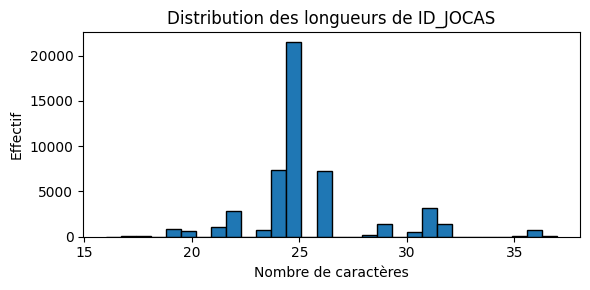

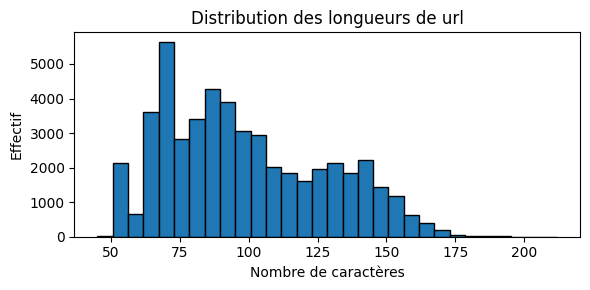

In [29]:
# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Variables d’identifiants / URL
id_vars = [
    "ID_JOCAS", "url",
    "MATCH_url_ID", "MATCH_dedup_ID", "MATCH_dedup_Tensions_ID"
]

n = len(df)

# 4️⃣ Calcul du taux de duplication
dup_metrics = []
for var in id_vars:
    if var not in df.columns:
        continue
    # on considère chaînes pour l'unicité
    series = df[var].dropna().astype(str)
    unique = series.nunique()
    dup_metrics.append(OrderedDict([
        ("Variable", var),
        ("Total lignes", n),
        ("Unique", unique),
        ("Unique %", unique / n * 100),
        ("Duplication %", (n - unique) / n * 100)
    ]))

dup_df = pd.DataFrame(dup_metrics)

# 5️⃣ Longueurs pour ID_JOCAS et url
len_metrics = []
for var in ["ID_JOCAS", "url"]:
    if var not in df.columns:
        continue
    lengths = df[var].dropna().astype(str).map(len)
    len_metrics.append(OrderedDict([
        ("Variable", var),
        ("Moyenne", lengths.mean()),
        ("Écart-type", lengths.std()),
        ("Min", lengths.min()),
        ("25 %", lengths.quantile(0.25)),
        ("50 %", lengths.median()),
        ("75 %", lengths.quantile(0.75)),
        ("Max", lengths.max())
    ]))

len_df = pd.DataFrame(len_metrics)

# 6️⃣ Affichage joli des tables
styled_dup = (
    dup_df
    .style
    .format({"Unique %":"{:.1f}%", "Duplication %":"{:.1f}%"})
    .bar(subset=["Unique %","Duplication %"], color=["lightgreen","salmon"])
    .set_caption("🔗 Taux d’unicité vs duplication")
)
display(styled_dup)

styled_len = (
    len_df
    .set_index("Variable")
    .style
    .format("{:.1f}", subset=["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max"])
    #.background_gradient(subset=["Moyenne","Écart-type","Min","25 %","50 %","75 %","Max"], cmap="Blues")
    .set_caption("📏 Statistiques de longueur – ID_JOCAS & URL")
)
display(styled_len)

# 7️⃣ Histogrammes de longueurs
for var in ["ID_JOCAS", "url"]:
    if var not in df.columns:
        continue
    lengths = df[var].dropna().astype(str).map(len)
    plt.figure(figsize=(6,3))
    plt.hist(lengths, bins=30, edgecolor='black')
    plt.title(f"Distribution des longueurs de {var}")
    plt.xlabel("Nombre de caractères")
    plt.ylabel("Effectif")
    plt.tight_layout()
    plt.show()


#### Champs texte (descriptions & titres)

,Variable,Non-null,Chars mean,Chars median,Chars std,Chars min,Chars 25%,Chars 75%,Chars max,Words mean,Words median,Words std,Words 25%,Words 75%,Tags mean,Tags std
0,job_title,50000,35.8,32.0,16.9,5,24,44,166,5.0,4.0,2.6,3,6,nan,nan
1,description_job,46673,1355.0,1131.0,958.9,14,677,1825,31879,201.4,168.0,140.8,102,270,nan,nan
2,description_profil,28255,546.8,464.0,366.3,1,272,756,3157,80.8,69.0,53.5,41,112,nan,nan
3,description_entreprise,21748,440.3,394.0,285.5,1,235,517,3261,66.7,62.0,42.9,35,81,nan,nan
4,description_full,49987,1624.1,1488.0,957.6,14,956,2115,31880,237.9,218.0,138.5,143,306,4.6,13.8


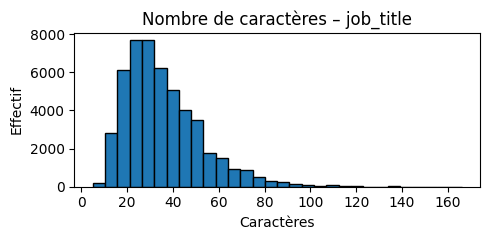

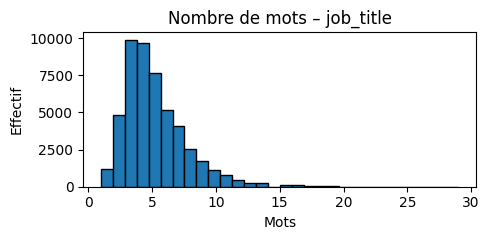

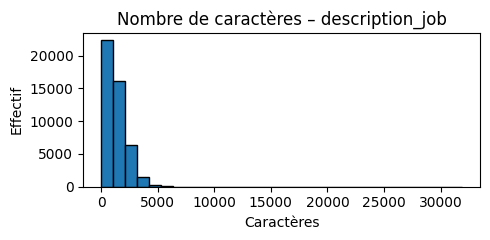

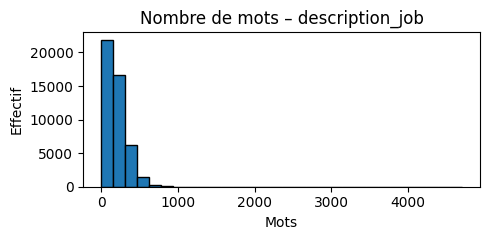

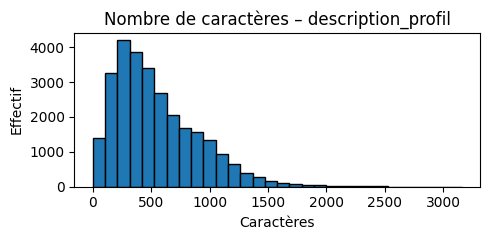

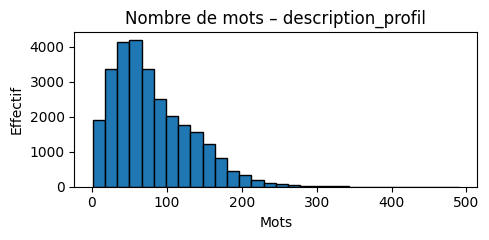

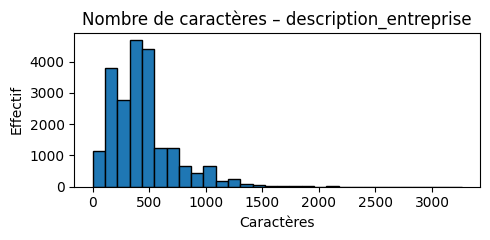

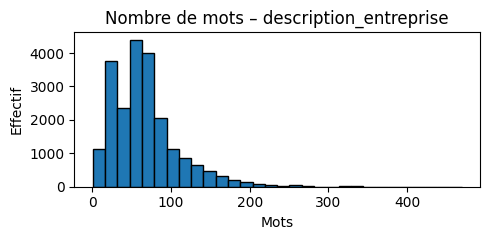

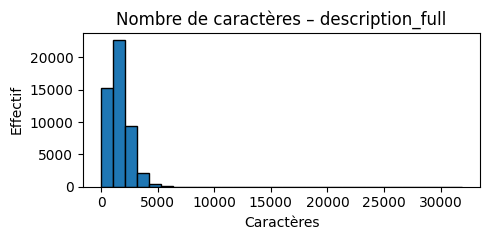

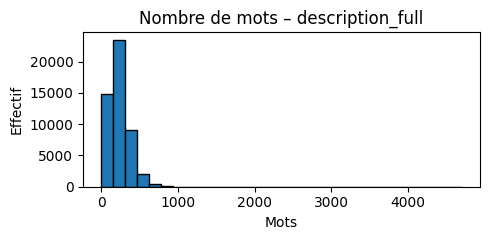

In [33]:
# 2️⃣ Lecture manuelle du JSONL
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line: 
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)

# 3️⃣ Liste des variables texte
text_vars = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full"
]

# 4️⃣ Construire le DataFrame de métriques texte
metrics = []
for var in text_vars:
    if var not in df.columns:
        continue
    series = df[var].dropna().astype(str)
    n = series.count()
    
    # longueurs en caractères
    lengths_char = series.map(len)
    # longueurs en mots
    lengths_word = series.map(lambda s: len(s.split()))
    # balises HTML (uniquement pour description_full)
    if var == "description_full":
        tags = series.map(lambda s: len(re.findall(r'<[^>]+>', s)))
    else:
        tags = pd.Series([pd.NA] * n)
    
    metrics.append(OrderedDict([
        ("Variable",         var),
        ("Non-null",         n),
        # Caractères
        ("Chars mean",       lengths_char.mean()),
        ("Chars median",     lengths_char.median()),
        ("Chars std",        lengths_char.std()),
        ("Chars min",        lengths_char.min()),
        ("Chars 25%",        lengths_char.quantile(0.25)),
        ("Chars 75%",        lengths_char.quantile(0.75)),
        ("Chars max",        lengths_char.max()),
        # Mots
        ("Words mean",       lengths_word.mean()),
        ("Words median",     lengths_word.median()),
        ("Words std",        lengths_word.std()),
        ("Words 25%",        lengths_word.quantile(0.25)),
        ("Words 75%",        lengths_word.quantile(0.75)),
        # Tags HTML
        ("Tags mean",        tags.mean()),
        ("Tags std",         tags.std()),
    ]))

metrics_df = pd.DataFrame(metrics)

# 5️⃣ Affichage du tableau stylé
styled = (
    metrics_df
      .style
      .format({
        "Non-null": "{:.0f}",
        "Chars mean":"{:.1f}", "Chars median":"{:.1f}", "Chars std":"{:.1f}",
        "Chars min":"{:.0f}", "Chars 25%":"{:.0f}", "Chars 75%":"{:.0f}", "Chars max":"{:.0f}",
        "Words mean":"{:.1f}", "Words median":"{:.1f}", "Words std":"{:.1f}",
        "Words 25%":"{:.0f}", "Words 75%":"{:.0f}",
        "Tags mean":"{:.1f}", "Tags std":"{:.1f}"
      })
      #.background_gradient(
       # subset=[c for c in metrics_df.columns if c not in ["Variable","Non-null"]],
        #cmap="Blues"
      #)
      .set_caption("📝 Statistiques descriptives – Champs texte")
)
display(styled)

# 6️⃣ Histogrammes pour chaque métrique pertinente
for var in text_vars:
    if var not in df.columns:
        continue
    s = df[var].dropna().astype(str)
    lengths_char = s.map(len)
    lengths_word = s.map(lambda x: len(x.split()))
    
    # Histogramme caractères
    plt.figure(figsize=(5,2.5))
    plt.hist(lengths_char, bins=30, edgecolor='black')
    plt.title(f"Nombre de caractères – {var}")
    plt.xlabel("Caractères")
    plt.ylabel("Effectif")
    plt.tight_layout()
    plt.show()
    
    # Histogramme mots
    plt.figure(figsize=(5,2.5))
    plt.hist(lengths_word, bins=30, edgecolor='black')
    plt.title(f"Nombre de mots – {var}")
    plt.xlabel("Mots")
    plt.ylabel("Effectif")
    plt.tight_layout()
    plt.show()


#### Variables de rémunération

,Variable,Non-null,% Rempli
0,salary_min,11659,23.3%
1,salary_max,6878,13.8%
2,salary_value,9671,19.3%
3,salary_hourly_min,9671,19.3%
4,salary_hourly_max,6350,12.7%
5,salary_hourly_mean,9671,19.3%
6,salary_period,9671,19.3%


,Mean,25%,50%,75%
Variable,,,,
salary_min,23679.54,18000.00,22000.00,30000.00
salary_max,32989.97,22000.00,31000.00,44000.00
salary_value,34.73,13.38,17.12,23.34
salary_hourly_min,31.97,12.45,15.56,21.79
salary_hourly_max,39.27,15.82,21.79,28.01
salary_hourly_mean,34.73,13.38,17.12,23.34


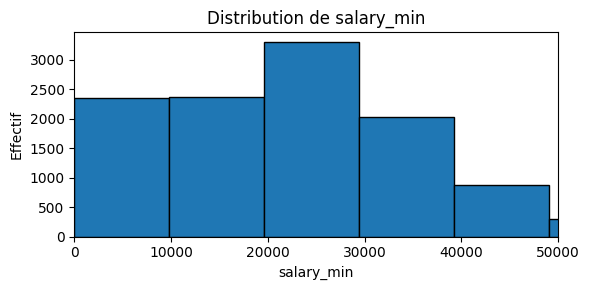

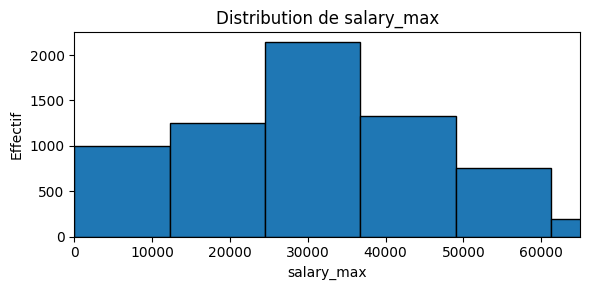

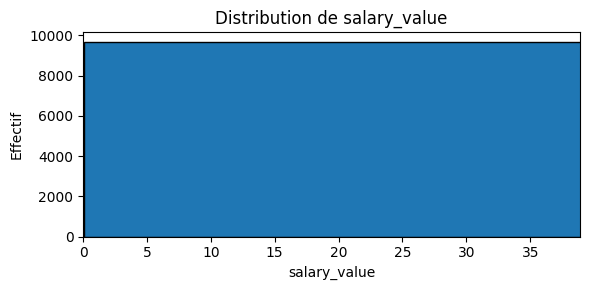

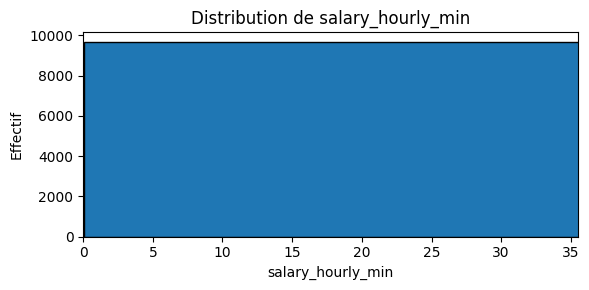

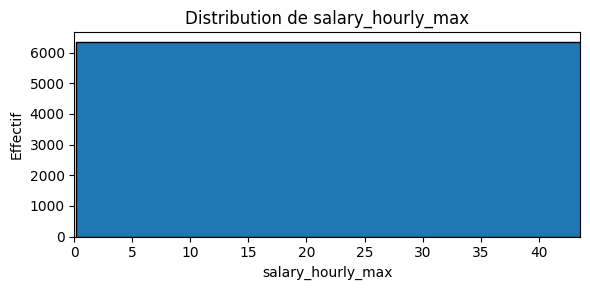

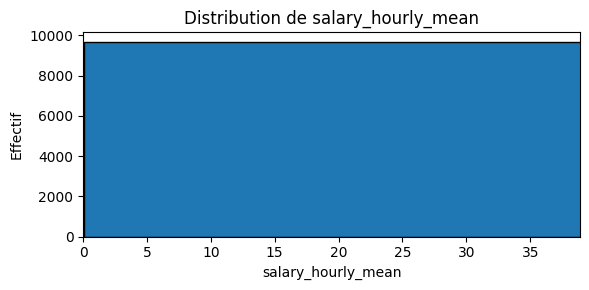

,Modalité,Pourcentage
0,YEAR,47.7%
1,YEAR_INFER,29.0%
2,HOUR,8.8%
3,MONTH,7.8%
4,HOUR_INFER,3.6%
5,MONTH_INFER,3.1%
6,DAY,0.0%
7,DAY_INFER,0.0%


In [35]:
# 2️⃣ Charger manuellement pour éviter les erreurs
records = []
with open(path, encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line: continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue
df = pd.DataFrame(records)
total = len(df)

# 3️⃣ Variables de rémunération
salary_vars = [
    "salary_min", "salary_max", "salary_value",
    "salary_hourly_min", "salary_hourly_max", "salary_hourly_mean",
    "salary_period"
]

# ——————————————————————————————
# 4️⃣ Taux de renseignement
fill_stats = []
for var in salary_vars:
    if var in df.columns:
        non_null = df[var].notna().sum()
        pct = non_null/total*100
        fill_stats.append(OrderedDict([
            ("Variable", var),
            ("Non-null", non_null),
            ("% Rempli", pct)
        ]))
fill_df = pd.DataFrame(fill_stats)
styled_fill = (
    fill_df
      .style
      .format({"Non-null":"{:.0f}", "% Rempli":"{:.1f}%"})
      .bar(subset=["% Rempli"], color="#85C1E9")
      .set_caption("💰 Taux de renseignement – Variables de rémunération")
)
display(styled_fill)

# ——————————————————————————————
# 5️⃣ Statistiques descriptives pour variables numériques
numeric_salary = [
    "salary_min", "salary_max", "salary_value",
    "salary_hourly_min", "salary_hourly_max", "salary_hourly_mean"
]
metrics = []
for var in numeric_salary:
    if var in df.columns:
        s = pd.to_numeric(df[var], errors='coerce').dropna()
        if s.empty: continue
        metrics.append(OrderedDict([
            ("Variable", var),
            ("Mean",       s.mean()),
            ("25%",        s.quantile(0.25)),
            ("50%",        s.median()),
            ("75%",        s.quantile(0.75))
        ]))
metrics_df = pd.DataFrame(metrics).set_index("Variable")
styled_metrics = (
    metrics_df
      .style
      .format("{:.2f}")
      #.background_gradient(cmap="Purples")
      .set_caption("📈 Statistiques descriptives – Variables numériques")
)
display(styled_metrics)

# ——————————————————————————————
# 6️⃣ Histogrammes (0–95ᵉ centile)
for var in numeric_salary:
    if var in df.columns:
        data = pd.to_numeric(df[var], errors='coerce').dropna()
        if data.empty: continue
        plt.figure(figsize=(6,3))
        plt.hist(data, bins=30, edgecolor='black')
        plt.title(f"Distribution de {var}")
        plt.xlabel(var); plt.ylabel("Effectif")
        lim = data.quantile(0.95)
        plt.xlim(0, lim)
        plt.tight_layout()
        plt.show()

# ——————————————————————————————
# 7️⃣ Distribution de salary_period
if "salary_period" in df.columns:
    sp = df["salary_period"].dropna().astype(str)
    vc = sp.value_counts(normalize=True).mul(100).round(1)
    period_df = pd.DataFrame({
        "Modalité": vc.index,
        "Pourcentage": vc.values
    }).head(10)
    styled_period = (
        period_df
          .style
          .format({"Pourcentage":"{:.1f}%"})
          .bar(subset=["Pourcentage"], color="#FFC107")
          .set_caption("🔖 Distribution – salary_period")
    )
    display(styled_period)
